# 1. Research statement and details
We want to know the answers for 2 related questions:
1. Can we use proximity graph cuts (PGC) to approximate class boundaries? If yes, which proximity graphs?
2. Can we build an instance-based classifiers using PGCs and how it overperforms classic approaches (kNN + techniques) in accuracy, speed and memory?

# 2. Datasets

We need to show that our methods work for different data: both low and highly dimensional, both small and big, both synthetic and real life, both noisy and clean:
1. Small low/high dimensional and big low/high dimensional clean synthetic dataset to justify that idea worth spending time (+4)
2. Small and big noisy datasets to see how noise influence the method (+4)
3. Small/big low/high dimensional real data dataset to see how the methods apply to real problems.

## 2.1. How the real dataset is distributed? Can we mimic?
Let's explore covtype dataset

In [1]:
import numpy as np

def read_to_numpy(path):
    X, y = np.zeros((581012, 54)),  []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            items = line.split()
            clas = items[0]
            pairs = [pair.split(':') for pair in items[1:]]
            for a, b in pairs:
                X[i, int(a) - 1] = float(b)
            y.append(clas)
    return X, y

X, y = read_to_numpy('../data/covtype/covtype.binary.scale')

X = np.nan_to_num(X)

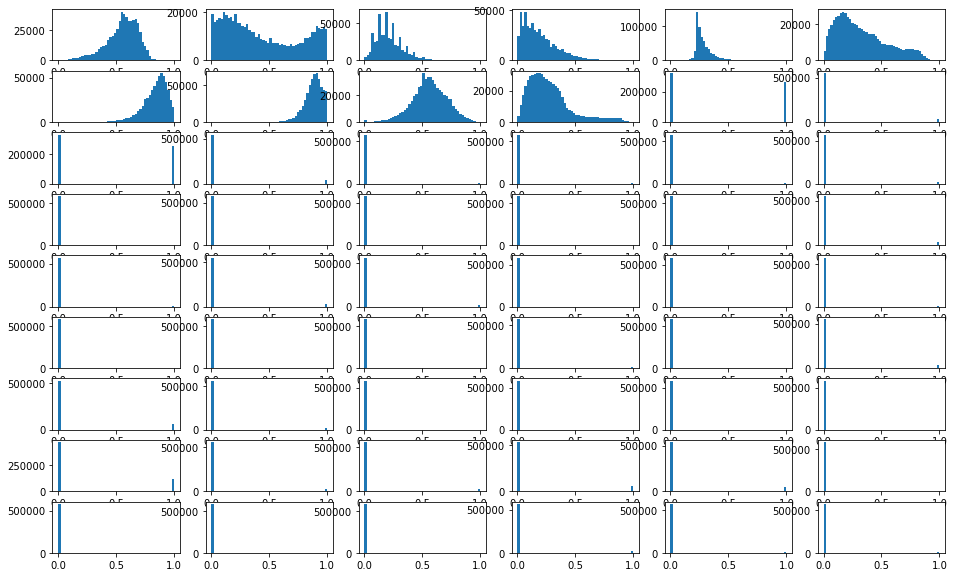

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 6, figsize=(16, 10))
for i in range(54):
    axs[i // 6, i % 6].hist(X[:, i], bins=50)

plt.show()

what about mutual feature distribution?

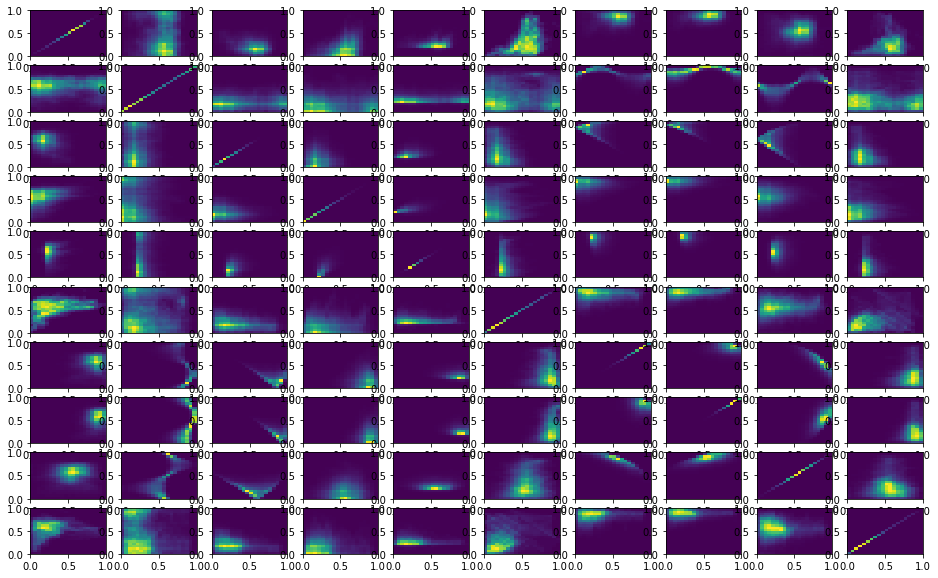

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(16, 10))
for i in range(10):
    for j in range(10):
        axs[i, j].hist2d(X[:, i], X[:, j], bins=20)

plt.show()

## 2.2. Can we use histogram to generate new data?

One way: to fit some distribution first. E.g. Dirichlet.

REF: https://tminka.github.io/papers/dirichlet/

```
@InProceedings{minka2000estimating,
author = {Minka, Tom},
title = {Estimating a Dirichlet Distribution},
year = {2000},
month = {September},
abstract = {The Dirichlet distribution and its compound variant, the Dirichlet-multinomial, are two of the most basic models for proportional data, such as the mix of vocabulary words in a text document. Yet the maximum-likelihood estimate of these distributions is not available in closed-form. This paper describes simple and efficient iterative schemes for obtaining parameter estimates in these models. In each case, a fixed-point iteration and a Newton-Raphson (or generalized Newton-Raphson) iteration is provided.},
url = {https://www.microsoft.com/en-us/research/publication/estimating-dirichlet-distribution/},
}
```

But to store a multivariate distribution of 54 dimensions we will run out of memory. This comes from the idea, that for pairwise correlations you need $bins^2$ for each pair, and for 54 dimensions we need $bins^{54}$, which for even 10 bins becomes enormously big value.

Many pairs of this dataset look like independent multivariate distributions. Thus we can generate few distributions for some features and then construct a multivariate generator.

What about feature correlation and covariation?

**Correlation** -- when expected value if Y depends on X value. Can be linear. If variance of Y depends on X, this is not correlation.

**Covariation** -- when independent variables rule $E(XY) = E(X)E(Y)$ fails. $cov(X,Y) = E(XY) - E(X)E(Y)$. The bigger is absolute value, the bigger is dependency. Covariance unit is squared unit of variables. We norm it by the spread to get *linear correlation coefficient*.

If linear correlation coefficient equals to 1/-1, then we have functional dependency. If it is 0, this doesn't mean independency -- they just don't *correlate*.

In [4]:
import pandas as pd
df = pd.DataFrame(X)

In [5]:
CX = df.corr()

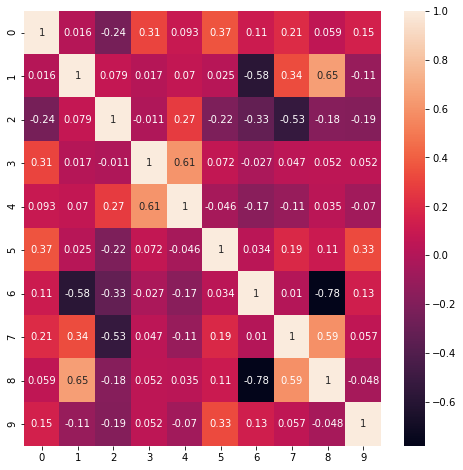

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt

CXA = np.array(CX)
plt.figure(figsize=(8, 8))
sn.heatmap(CXA[:10, :10], annot=True)
plt.show()

Some pairs show non-marginal correlation. TODO: and what?

Thanks to https://stackoverflow.com/a/63762024 for the loop

In [7]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=20)
while True: 
    try: 
        print("iteration")
        pca.fit(X)
        break 
    except: continue

iteration
iteration


In [8]:
sum(pca.explained_variance_ratio_)

0.8800448854431941

### 2.2.1. Generate a dataset with given list of histograms

Refer to https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

In [2]:
DATASET_SIZE = 50000

In [3]:
from scipy.stats import rv_histogram
def generate_by_hists(hists, N):
    result = np.zeros((N, len(hists)))
    for i, hist in enumerate(hists):
        distr = rv_histogram(hist)
        result[:, i] = distr.rvs(size=N)
    return result
        
np.random.seed(1234567)
hists = [np.histogram(X[:, col]) for col in range(X.shape[1])]
Xprime = generate_by_hists(hists, DATASET_SIZE)

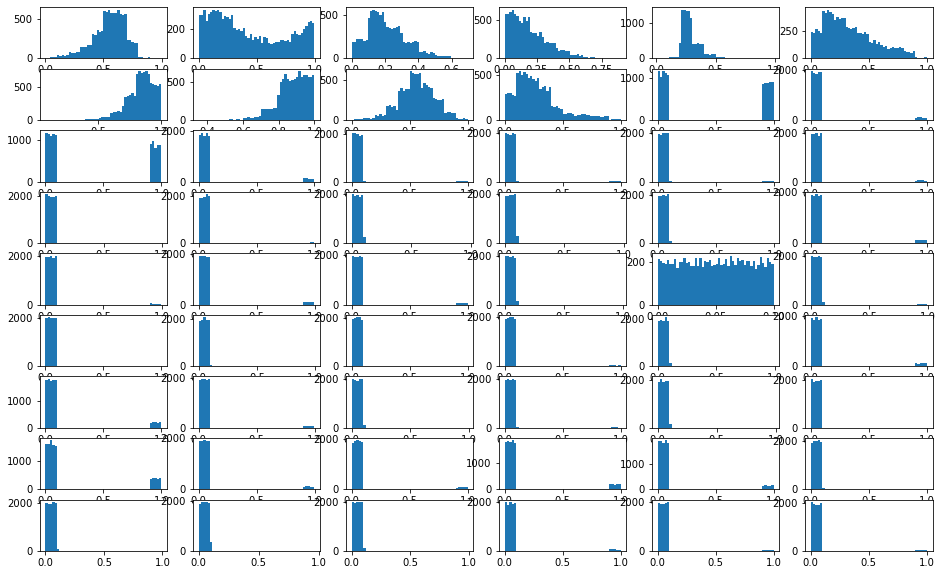

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 6, figsize=(16, 10))
for i in range(54):
    axs[i // 6, i % 6].hist(Xprime[:, i], bins=50)

plt.show()

2 features feels like spoiled (just 0-s in original hist).

# 2.3. Ok, how we create a class boundary?

We need a synthetic boundary, which allows us to easily compute distance from random point to it. Spherical is an interesting approach (TBD).

In [4]:
import numpy as np
from numpy.linalg import norm

def split_dataset_linearly(X):
    # find a mean point for each axis
    M = np.mean(X, axis=0)
    # any hyperplane through this point will split the data into 2 parts exactly
    np.random.seed(0)
    K = np.random.rand(X.shape[1], 1) * 2 - 1
    # we will use (X - M) dot K to decide a class
    Xc = (X - M) @ K    
    # whatever is higher than hyperplane is 1
    classes = (Xc > 0).flatten().astype(int)
    return classes, M, K

yprime, M, K = split_dataset_linearly(Xprime)
I = np.dot(M, K)[0] / norm(K)
sum(yprime), len(yprime) - sum(yprime)

(24935, 25065)

`K` here corresponds to decision plane coefficients. Same (but scaled) coefficients are produced by linear regression model.

`Intercept` will be a value of `Y` with `X=0`, in our case this is `(-M @ K)`.

Let's check that we created a linearly separable model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(Xprime, yprime, test_size=0.4, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10060
           1       0.98      0.98      0.98      9940

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



C:\Users\stani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The report should show a linear classifier with very high accuracy value. So yes, we have a nice dataset.

In [42]:
from numpy.linalg import norm 

def signed_dist_to_plane(point, K, I):
    return np.dot(point, K)[0] / norm(K) - I

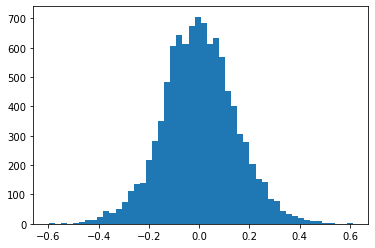

In [7]:
import matplotlib.pyplot as plt

dst = [signed_dist_to_plane(x, K, I) for x in Xprime]
plt.hist(dst, bins=50)
plt.show()

Ok we have a generated dataset and a tool to estimate a distance from arbitrary point to it's decision boundary.

# 3. Building a proximity graphs

We will build different proximity graphs for the given dataset. Our task is to measure:
% - *theoretical and measured build complexity for each of them
- space complexity for graph
- quality of border estimation with RMSE
- space complexity of graph cut

For experimental purposes we will stick to a medium-size dataset 10000 with items, which will make possible to complete construction of all graph types on a single machine.

In [11]:
import os
import networkx as nx
import time

def cached_graph(name, dataset, function):
    fname = f"../dumps/{name}-{len(dataset)}.pickle"
    if os.path.exists(fname):
        print("From cache", fname)
        graph = nx.read_gpickle(fname)
    else:
        print("Sorry, need to build from scratch")
        t = time.time()
        graph = function(dataset)
        t = time.time() - t
        print(f"Done in {t:.3} seconds")
        nx.write_gpickle(graph, fname)
    return graph

## 3.a. Complete graph

In [7]:
import numpy as np
import networkx as nx
import tqdm

def get_complete(dataset):
    import tqdm
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        for b in range(a + 1, len(dataset)):
            graph.add_edge(a, b, weight=dists[a, b])
    return graph

In [ ]:
cached_graph("complete", Xprime[:5000], get_complete)
cached_graph("complete", Xprime[:10000], get_complete)

Sorry, need to build from scratch


100%|██████████| 5000/5000 [00:31<00:00, 161.00it/s] 


Done in 32.9 seconds


## 3.b. Gabriel

In [8]:
import numpy as np
import networkx as nx
import bisect
from numba import jit
from numba import typed, types
import time

import tqdm

@jit
def get_gabriel_numba(dists, result):
    # result = typed.List()
    for a in range(len(dists)):
        for b in range(len(dists)):
            if a == b: continue
            ab = dists[a, b]
            is_gabriel = True
            for t in range(len(dists)):
                if a == t or b == t:
                    continue
                at = dists[a, t]
                tb = dists[t, b]
                if (at ** 2 + tb ** 2)  < ab ** 2:
                    is_gabriel = False
                    break
            if is_gabriel:
                l = typed.List.empty_list(types.int64, 2)
                l.append(a)
                l.append(b)
                result.append(l)
    return result


def get_gabriel_fast(dataset):
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    small = typed.List()
    small.append(0)
    result = typed.List()
    result.append(small)
    result.pop()
    get_gabriel_numba(dists, result)
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    graph.add_weighted_edges_from([(kv[0], kv[1], dists[kv[0], kv[1]]) for kv in result])
    return graph
    

def get_gabriel(dataset):
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        dist_idx = np.argsort(dists[a, :])
        for b in dist_idx:
            if a == b:
                continue
            ab = dists[a, b]
            first_greater = bisect.bisect_left(dists[a, dist_idx], ab)
            is_gabriel = True
            for t in dist_idx[:first_greater]:
                if a == t or b == t:
                    continue
                at = dists[a, t]
                tb = dists[t, b]
                if (at ** 2 + tb ** 2)  < ab ** 2:
                    is_gabriel = False
                    break
            if is_gabriel:
                graph.add_edge(a, b, weight=ab)
    
    return graph

In [16]:
cached_graph("gabriel", Xprime[:1000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:2000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:4000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:5000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:10000], get_gabriel_fast)
cached_graph("gabriel", Xprime[:20000], get_gabriel_fast)
# cached_graph("gabriel", Xprime[:300000], get_gabriel_fast)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/gabriel-20000.pickle


## 3.c. Gabriel derivatives: RNG, NNG and EMST

- https://en.wikipedia.org/wiki/Euclidean_minimum_spanning_tree
- https://github.com/AndrewB330/EuclideanMST

In [9]:
def get_nng_from_gabriel(graph):
    nng = nx.DiGraph()
    nng.add_nodes_from(graph.nodes)
    for node in graph.nodes:
        m, i = None, None
        for nn, w in graph[node].items():
            if m is None or w['weight'] < m:
                i = nn
                m = w['weight']
        nng.add_edge(node, i, weight=m)
    return nng


def get_rng_from_gabriel(graph):
    ''' 
    As RNG is a subset of a Gabriel graph, thus we can construct one of 
    another by examining existing neighbourhoods: we test existing edge ends
    for having a shared neighbour with smaller distance
    '''
    rng = nx.Graph()
    rng.add_nodes_from(graph.nodes)
    for src, dst, w in graph.edges.data("weight", default=None):
        intersect = set.intersection(set(graph.neighbors(src)), set(graph.neighbors(dst)))
        keep = True
        for transit in intersect:
            if w > graph[src][transit]['weight'] and w > graph[dst][transit]['weight']:
                keep = False
                break
        if keep:
            rng.add_edge(src, dst, weight=w)
    return rng


def get_emst(graph):
    emst = nx.minimum_spanning_tree(graph)
    return emst

In [22]:
cached_graph("nng", cached_graph("gabriel", Xprime[:1000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:2000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:4000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:5000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:10000], get_gabriel_fast), get_nng_from_gabriel)
cached_graph("nng", cached_graph("gabriel", Xprime[:20000], get_gabriel_fast), get_nng_from_gabriel)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/nng-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/nng-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/nng-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/nng-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/nng-10000.pickle
From cache ../dumps/gabriel-20000.pickle
From cache ../dumps/nng-20000.pickle


In [24]:
cached_graph("rng", cached_graph("gabriel", Xprime[:1000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:2000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:4000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:5000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:10000], get_gabriel_fast), get_rng_from_gabriel)
cached_graph("rng", cached_graph("gabriel", Xprime[:20000], get_gabriel_fast), get_rng_from_gabriel)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/rng-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/rng-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/rng-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/rng-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/rng-10000.pickle
From cache ../dumps/gabriel-20000.pickle
From cache ../dumps/rng-20000.pickle


In [26]:
cached_graph("emst", cached_graph("gabriel", Xprime[:1000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:2000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:4000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:5000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:10000], get_gabriel_fast), get_emst)
cached_graph("emst", cached_graph("gabriel", Xprime[:20000], get_gabriel_fast), get_emst)

From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/emst-1000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/emst-2000.pickle
From cache ../dumps/gabriel-4000.pickle
From cache ../dumps/emst-4000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/emst-5000.pickle
From cache ../dumps/gabriel-10000.pickle
From cache ../dumps/emst-10000.pickle
From cache ../dumps/gabriel-20000.pickle
From cache ../dumps/emst-20000.pickle


## 3.d. NSW

In [10]:
import sys
sys.path.append('../modules')
from nsw.nsw import Node, NSWGraph

In [11]:
G = NSWGraph()
data_sample = [(x, y) for x, y in zip(Xprime[:1000], yprime[:1000])]
G.build_navigable_graph(data_sample, attempts=1)

In [16]:
import networkx as nx
from scipy import spatial
from tqdm import tqdm

def nsw_to_nx(nsw):
    g = nx.Graph()
    g.add_nodes_from(range(len(nsw.nodes)))
    
    for (a, b) in tqdm(nsw.get_edges()):
        va = nsw.nodes[a].value
        vb = nsw.nodes[b].value
        w = spatial.distance.cosine(va, vb)
        g.add_edge(a, b, weight=w)
    return g

# nsw_to_nx(G)

In [18]:
for s in [1000, 2000, 5000, 10000]:
    G = NSWGraph()
    data_sample = [(x, y) for x, y in zip(Xprime[:s], yprime[:s])]
    G.build_navigable_graph(data_sample, attempts=1)
    cached_graph("nsw", G, nsw_to_nx)

From cache ../dumps/nsw-1000.pickle


2728it [00:00, 25993.87it/s]

Sorry, need to build from scratch


621594it [00:27, 22784.53it/s]


Done in 27.3 seconds


1142it [00:00, 11313.79it/s]

Sorry, need to build from scratch


1593594it [01:31, 17455.04it/s]


Done in 91.3 seconds


2148it [00:00, 20657.62it/s]

Sorry, need to build from scratch


3213594it [02:25, 22044.54it/s]


Done in 1.46e+02 seconds


## 3.e. Radius NG with BallTree

**NB we exclude these trees from publication, as they require hyperparameter definition, and this makes them mimic other graphs.**

sci-kit learn uses BallTree data structure to build proximity graph. Thus, thee construction is the essential part of algorithm.
But when in comes to $D > 15$, they use just a brute force technique.

### Ball Tree construction 
itself is enournously fast, as it guarantees log time search for low dimensions.

In [ ]:
from sklearn.neighbors import BallTree
import time

### Currently, algorithm = 'auto' selects 'brute' if any of the following conditions are verified
### when D > 15, the intrinsic dimensionality of the data is generally too high for tree-based methods
print("data\tleaf s.\tconstr. time\tdatashape")
for datasetsize in [1000, 10000, 50000, 100000, 200000]:
    for ls in [1, 10, 50, 100]:
        start = time.time()
        bt = BallTree(Xprime[:datasetsize], leaf_size=ls)
        t = time.time() - start
        print(f'{datasetsize}\t{ls}\t{t:1.6}\t{bt.data.shape}') 

links:
- https://scikit-learn.org/stable/modules/neighbors.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.radius_neighbors_graph.html#sklearn.neighbors.radius_neighbors_graph
- http://ftp.icsi.berkeley.edu/ftp/pub/techreports/1989/tr-89-063.pdf - BallTree is used as a default approach for NN search queries
- http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.91.8209

So here we can observe, that using BallTree or brute force does not affect the quality (`True` values to the right mean the algorithms return excactly the same result). But bring valuable 

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
import time
from collections import Counter

# do tests on sizes, times
rads = [0.1, 0.5, 1, 5]
sizes = [100, 1000, 2000, 4000, 6000, 8000, 10000]
jobs = [1, 2, 4]

times_brute = np.zeros((len(rads), len(sizes), len(jobs)))
times_ball = np.zeros((len(rads), len(sizes), len(jobs)))
degrees = np.zeros((len(rads), len(sizes), len(jobs)))

for i, radius in enumerate(rads):
    for j, datasetsize in enumerate(sizes):
        for k, njobs in enumerate(jobs):
            
            start = time.time()
            rNG_B = radius_neighbors_graph(Xprime[:datasetsize], radius=radius, n_jobs=njobs)
            t0 = time.time() - start
            
            graphdegree0 = len(rNG_B.nonzero()[0])
            print(f'{njobs}\t{datasetsize}\t{radius}\t{t0}\t{graphdegree0}\t', end="")
            
            start = time.time()
            bt = BallTree(Xprime[:datasetsize])
            rNG_T = radius_neighbors_graph(bt, radius=radius, n_jobs=njobs)
            t1 = time.time() - start
            graphdegree1 = len(rNG_T.nonzero()[0])
            tst = np.allclose(rNG_B.toarray(), rNG_T.toarray())
            
            print(f'{njobs}\t\t{t1}\t{graphdegree1}\t{tst}')
            
            times_brute[i, j, k] = t0 
            times_ball[i, j, k] = t1 
            degrees[i, j, k] = graphdegree1

In [ ]:
# rad 0.5, 4 threads
plt.plot(sizes, times_brute[2, :, 2], label="brute")
plt.plot(sizes, times_ball[2, :, 2], label="ball")
plt.xlabel("nodes")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

plt.plot(sizes, degrees[2, :, 2], label="edges in rad 0.5")
plt.xlabel("nodes")
plt.ylabel("edges")
plt.legend()
plt.show()

# rad 0.5, 4 threads
plt.plot(degrees[2, :, 2], times_brute[2, :, 2], label="brute")
plt.plot(degrees[2, :, 2], times_ball[2, :, 2], label="ball")
plt.xlabel("edges")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

Looks like a polynomial construction time for both nodes and edges

## 3.f. k-NN graph with BallTree
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

In [ ]:
# from sklearn.neighbors import kneighbors_graph

# for n in [1, 2, 5, 10, 20, 50, 100]:
#     for datasetsize in [1000, 10000, 20000, 40000]:
#             start = time.time()
#             kNN = kneighbors_graph(Xprime[:datasetsize], n_neighbors=n)
#             t = time.time() - start
#             graphdegree = len(kNN.nonzero()[0])
#             # spread = Counter(rNG.nonzero()[0])
#             # print(spread.most_common(10))
#             print(f'{datasetsize}\t{n}\t{t}\t{graphdegree}') 

In [ ]:
from sklearn.neighbors import kneighbors_graph
import time
from collections import Counter

# do tests on sizes, times
ns_k = [1, 2, 5, 10, 20, 50, 100]
sizes_k = [1000, 2000, 3000, 4000, 5000, 8000, 10000]
jobs_k = [1, 2, 4]

times_brute_k = np.zeros((len(ns_k), len(sizes_k), len(jobs_k)))
times_ball_k = np.zeros((len(ns_k), len(sizes_k), len(jobs_k)))
degrees_k = np.zeros((len(ns_k), len(sizes_k), len(jobs_k)))

for i, n in enumerate(ns_k):
    for j, datasetsize in enumerate(sizes_k):
        for k, njobs in enumerate(jobs_k):
            
            start = time.time()
            kNN_B = kneighbors_graph(Xprime[:datasetsize], n_neighbors=n, n_jobs=njobs)
            t0 = time.time() - start
            
            graphdegree0 = len(kNN_B.nonzero()[0])
            print(f'{njobs}\t{datasetsize}\t{n}\t{t0}\t{graphdegree0}\t', end="")
            
            start = time.time()
            bt = BallTree(Xprime[:datasetsize])
            kNN_T = kneighbors_graph(bt, n_neighbors=n, n_jobs=njobs)
            t1 = time.time() - start
            graphdegree1 = len(kNN_T.nonzero()[0])
            tst = np.allclose(kNN_B.toarray(), kNN_T.toarray())
            
            print(f'{njobs}\t\t{t1}\t{graphdegree1}\t{tst}')
            
            times_brute_k[i, j, k] = t0 
            times_ball_k[i, j, k] = t1 
            degrees_k[i, j, k] = graphdegree1

In [ ]:
# n = 100, 4 threads
plt.plot(sizes, times_brute_k[6, :, 2], label="brute")
plt.plot(sizes, times_ball_k[6, :, 2], label="ball")
plt.xlabel("nodes")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

plt.plot(sizes, degrees_k[6, :, 2], label="edges in n = 100")
plt.xlabel("nodes")
plt.ylabel("edges")
plt.legend()
plt.show()

# n = 20, 4 threads
plt.plot(sizes, times_brute_k[4, :, 2], label="brute")
plt.plot(sizes, times_ball_k[4, :, 2], label="ball")
plt.xlabel("nodes")
plt.ylabel("construction time, sec")
plt.legend()
plt.show()

plt.plot(sizes, degrees_k[4, :, 2], label="edges in n = 20")
plt.xlabel("nodes")
plt.ylabel("edges")
plt.legend()
plt.show()

# 4. GET CUT

In [13]:
def get_cut(graph, labels):
    return [e for e in graph.edges.data("weight", default=None) if labels[e[0]] != labels[e[1]]]

In [37]:
graph_sizes = [1000, 2000, 5000]
graph_types = {
    'complete': get_complete,
    'gabriel': get_gabriel,
    'emst': get_emst,
    'rng': get_rng_from_gabriel,
    'nng': get_nng_from_gabriel,
    'nsw': nsw_to_nx
}

cuts = {}

for s in graph_sizes:
    for name, func in graph_types.items():
        # print(name, func)
        g = cached_graph(name, Xprime[:s], func)
        cuts[(name, s)] = get_cut(g, yprime)

From cache ../dumps/complete-1000.pickle
From cache ../dumps/gabriel-1000.pickle
From cache ../dumps/emst-1000.pickle
From cache ../dumps/rng-1000.pickle
From cache ../dumps/nng-1000.pickle
From cache ../dumps/nsw-1000.pickle
From cache ../dumps/complete-2000.pickle
From cache ../dumps/gabriel-2000.pickle
From cache ../dumps/emst-2000.pickle
From cache ../dumps/rng-2000.pickle
From cache ../dumps/nng-2000.pickle
From cache ../dumps/nsw-2000.pickle
From cache ../dumps/complete-5000.pickle
From cache ../dumps/gabriel-5000.pickle
From cache ../dumps/emst-5000.pickle
From cache ../dumps/rng-5000.pickle
From cache ../dumps/nng-5000.pickle
From cache ../dumps/nsw-5000.pickle


complete	1000	249744
gabriel	1000	1376
emst	1000	219
rng	1000	785
nng	1000	193
nsw	1000	63942
complete	2000	999676
gabriel	2000	6084
emst	2000	1000
rng	2000	2954
nng	2000	1012
nsw	2000	120941
complete	5000	6249424
gabriel	5000	18420
emst	5000	2405
rng	5000	7542
nng	5000	2412
nsw	5000	267015


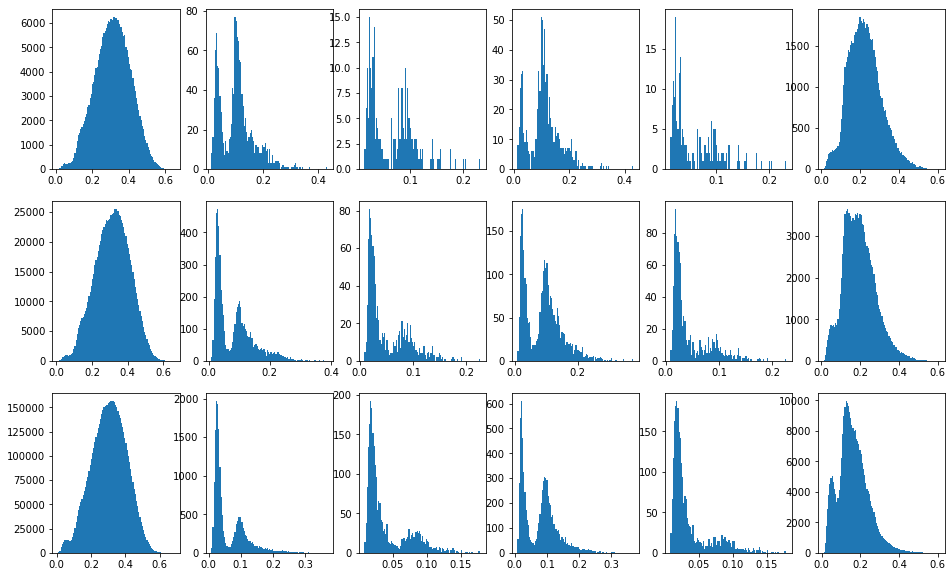

In [38]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(graph_sizes), len(graph_types), figsize=(16, 10))

for i, cut in enumerate(cuts):
    print(*cut, len(cuts[cut]), sep='\t')
    data = [x[2] for x in cuts[cut]]
    axs[i // len(graph_types), i % len(graph_types)].hist(data, bins=100)
plt.show()

In [53]:
def get_points(dataset, cut, lim=None):
    for e in cut:
        if lim is not None:
            if e[2] > lim:
                continue
        p = (dataset[e[0]] + dataset[e[1]]) / 2
        yield p

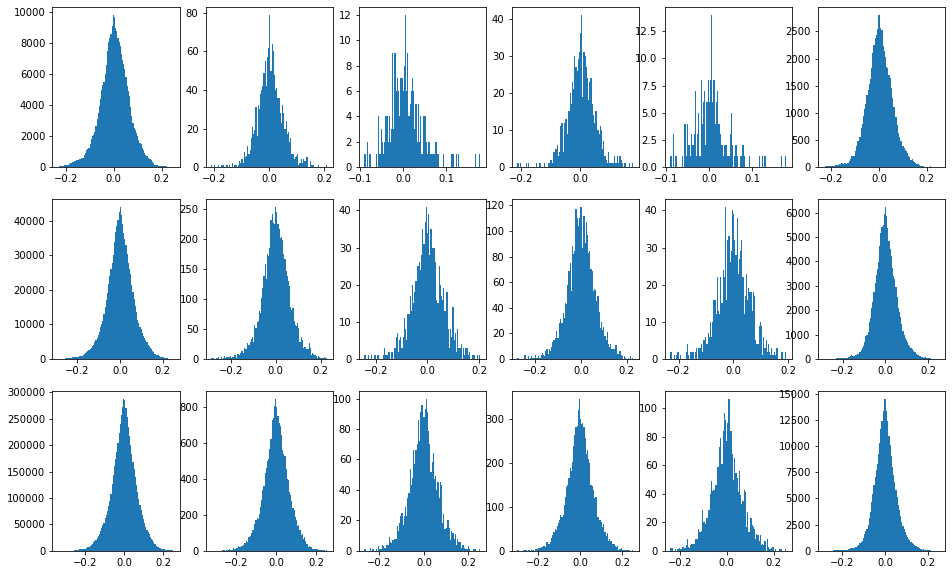

In [47]:
fig, axs = plt.subplots(len(graph_sizes), len(graph_types), figsize=(16, 10))

for i, cut in enumerate(cuts):
    res = []
    for point in get_points(Xprime, cuts[cut]):
        r = signed_dist_to_plane(point, K, I)
        res.append(r)

    axs[i // len(graph_types), i % len(graph_types)].hist(res, bins=100)
plt.show()

In [54]:
for i, cut in enumerate(cuts):
    res = []
    for point in get_points(Xprime, cuts[cut], lim=0.05):
        r = signed_dist_to_plane(point, K, I)
        res.append(r)
    print(cut, (np.dot(res, res) / len(res)) ** .5)
    axs[i // len(graph_types), i % len(graph_types)].hist(res, bins=100)
plt.show()

('complete', 1000) 0.02907085490322979
('gabriel', 1000) 0.029606189301936328
('emst', 1000) 0.025668060673652935
('rng', 1000) 0.026623293164879287
('nng', 1000) 0.02621893942320286
('nsw', 1000) 0.02907085490322979
('complete', 2000) 0.026531226313951755
('gabriel', 2000) 0.06460805545406467
('emst', 2000) 0.06273528208571788
('rng', 2000) 0.06346200769853627
('nng', 2000) 0.06163840911523888
('nsw', 2000) 0.02653122631395175
('complete', 5000) 0.0665374607399258
('gabriel', 5000) 0.06553909023597378
('emst', 5000) 0.06572860197255022
('rng', 5000) 0.06537480790111756
('nng', 5000) 0.06565091139526094
('nsw', 5000) 0.027015458694093383


# 5.0. New classifier

Pairwise distance of cut-based points approximating the class boundary


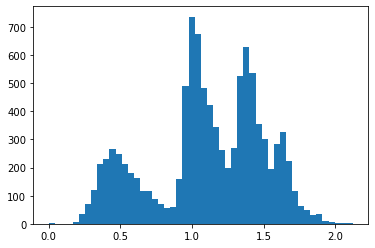

1.1085746667799092
Values for RBF for approximate points compared to first


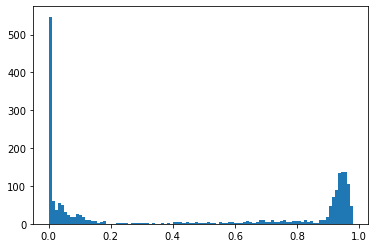

In [174]:
import numpy as np
import math
import random

def rbf(x, c, sigma):
    d2 = np.dot(x - c, x - c)
    s2 = sigma ** 2
    if s2 < d2:
        return 0.0
    
    return math.exp(1 - 1 / (1 - d2 / s2))
  
points = list(get_points(Xprime, cuts[('nsw', 2000)], lim=0.05))

print("Pairwise distance of cut-based points approximating the class boundary")
pwd = []
Q = 10000
for i in range(Q):
    a, b = random.choice(points), random.choice(points)
    pwd.append(np.linalg.norm(a - b))
plt.hist(pwd, bins=50)
plt.show()
print(sum(pwd) / len(pwd))


print("Values for RBF for approximate points compared to first")
rf = []
R = sum(pwd) / len(pwd)
for p in Xprime[:2000]:
    mx = 0
    for brd in points:
        mx = max(mx, rbf(p, brd, R))
    rf += [mx]
    
plt.hist(rf, bins=100)
plt.show()

In [232]:
def get_potential_func(points):
    random.seed(13)
    pwd = []
    Q = 1000
    for i in range(Q):
        a, b = random.choice(points), random.choice(points)
        pwd.append(np.linalg.norm(a - b))
    R = sum(pwd) / len(pwd)

    def _f(x):
        result = 0
        for brd in points:
            result += rbf(x, brd, R)
        return result
    
    return _f

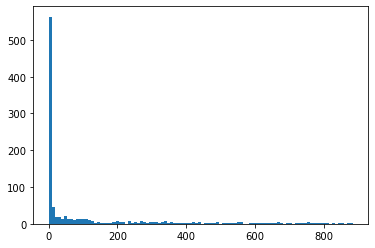

In [178]:
f = get_potential_func(points)
d = [f(p) for p in Xprime[:1000]]
plt.hist(d, 100)
plt.show()

## 5.1. Classifier

1. Select a support set of 10%

In [192]:
from nsw.nsw import Node, NSWGraph
import random

def get_support_index(dataset, labels, verbose=False):
    random.seed(13)
    support_size = len(dataset) // 10
    support = []
    for i in range(support_size):
        n = random.randrange(len(dataset))
        support.append((dataset[n], labels[n]))
    support_nsw = NSWGraph()
    support_nsw.build_navigable_graph(support, verbose=verbose)
    return support_nsw

In [193]:
support_graph = get_support_index(Xprime[:2000], yprime, verbose=True)

Data dimensionality detected is 54. regularity = 162
	10.00% of graph construction
	20.00% of graph construction
	30.00% of graph construction
	40.00% of graph construction
	50.00% of graph construction
	60.00% of graph construction
	70.00% of graph construction
	80.00% of graph construction
	90.00% of graph construction


In [198]:
from collections import Counter
def simple_knn(p, support_graph, k=5):
    c = Counter()
    result = support_graph.multi_search(p, attempts=10, top=k)
    for i in result:
        c[support_graph.nodes[i]._class] += 1
    return c.most_common(1)[0][0]

In [279]:
r = []
for p in Xprime[:100]:
    r.append(simple_knn(p, support_graph))

from sklearn.metrics import classification_report

print(classification_report(yprime[:100], r))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76        45
           1       0.88      0.64      0.74        55

    accuracy                           0.75       100
   macro avg       0.77      0.76      0.75       100
weighted avg       0.78      0.75      0.75       100



0 ~ 0 = 0.0 1 1
0 ~ 1 = 673.048963949326 1 0
1 ~ 2 = 324.450993354376 0 1
0 ~ 2 = 830.380179102345 1 1
7 ~ 7 = 0.0 0 0


  0%|          | 0/16 [00:00<?, ?it/s]

7 ~ 14 = 30.91527264850888 0 0


100%|██████████| 16/16 [00:49<00:00,  3.07s/it]


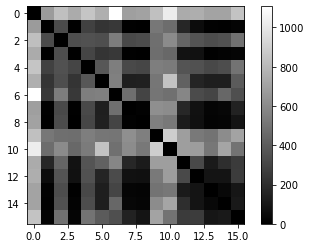

In [273]:
def detector(a, b, func, N=16):
    if np.allclose(a, b):
        return 0.0
    step = (a - b) / N
    # print(step)
    steplen = np.linalg.norm(step)
    points = np.linspace(a, b, N + 1)
    I = 0
    for i in range(1, N):
        I = max(I, func(points[i]))
    return I


f = get_potential_func(points)
for (a, b) in [(0, 0), (0, 1), (1, 2), (0, 2), (7, 7), (7, 14)]:
    print(f"{a} ~ {b} = {detector(Xprime[a], Xprime[b], f)}", yprime[a], yprime[b])

K = 16
x = np.zeros((K, K))
for i, p in enumerate(tqdm.tqdm(Xprime[:K])):
    for j, q in enumerate(Xprime[:K]):
        x[i, j] = detector(p, q, f)

cs = plt.imshow(x, cmap='gray')
plt.colorbar(cs)
plt.show()


In [275]:
def border_crossing_knn(p, support_graph, potential_func, thresh=100, k=5):
    c = Counter()
    result = support_graph.multi_search(p, attempts=10, top=k)

    for i in result:
        I = detector(p, support_graph.nodes[i].value, potential_func)
        if I < thresh:
            c[support_graph.nodes[i]._class] += 1
        else:
            c[1 - support_graph.nodes[i]._class] += 1
    return c.most_common(1)[0][0]

In [278]:
from sklearn.metrics import classification_report
for t in [400, 500, 650, 800]:
    print(t)
    r = []
    for p in tqdm.tqdm(Xprime[:100]):
        r.append(border_crossing_knn(p, support_graph, f, thresh=t))
    print(classification_report(yprime[:100], r))

  0%|          | 0/100 [00:00<?, ?it/s]

400


  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        45
           1       0.79      0.60      0.68        55

    accuracy                           0.69       100
   macro avg       0.70      0.70      0.69       100
weighted avg       0.71      0.69      0.69       100

500


  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.87      0.76        45
           1       0.86      0.65      0.74        55

    accuracy                           0.75       100
   macro avg       0.76      0.76      0.75       100
weighted avg       0.77      0.75      0.75       100

650


  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.69      0.84      0.76        45
           1       0.84      0.69      0.76        55

    accuracy                           0.76       100
   macro avg       0.77      0.77      0.76       100
weighted avg       0.78      0.76      0.76       100

800


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]

              precision    recall  f1-score   support

           0       0.67      0.82      0.74        45
           1       0.82      0.67      0.74        55

    accuracy                           0.74       100
   macro avg       0.75      0.75      0.74       100
weighted avg       0.75      0.74      0.74       100



# 6. Pipeline

## 6.0. Dataset construction

In [1]:
import numpy as np

def read_to_numpy(path):
    X, y = np.zeros((581012, 54)),  []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            items = line.split()
            clas = items[0]
            pairs = [pair.split(':') for pair in items[1:]]
            for a, b in pairs:
                X[i, int(a) - 1] = float(b)
            y.append(clas)
    return X, y

X, y = read_to_numpy('../data/covtype/covtype.binary.scale')
X = np.nan_to_num(X)

In [2]:
DATASET_SIZE = 20000

In [3]:
from scipy.stats import rv_histogram
def generate_by_hists(hists, N):
    result = np.zeros((N, len(hists)))
    for i, hist in enumerate(hists):
        distr = rv_histogram(hist)
        result[:, i] = distr.rvs(size=N)
    return result
        
np.random.seed(1234567)
hists = [np.histogram(X[:, col]) for col in range(X.shape[1])]
Xprime = generate_by_hists(hists, DATASET_SIZE)

In [4]:
import numpy as np

def split_dataset_linearly(X):
    # find a mean point for each axis
    M = np.mean(X, axis=0)
    # any hyperplane through this point will split the data into 2 parts exactly
    np.random.seed(0)
    K = np.random.rand(X.shape[1], 1) * 2 - 1
    # we will use (X - M) dot K to decide a class
    Xc = (X - M) @ K    
    # whatever is higher than hyperplane is 1
    classes = (Xc > 0).flatten().astype(int)
    return classes, M, K

yprime, M, K = split_dataset_linearly(Xprime)
I = np.dot(M, K)[0] / np.linalg.norm(K)
sum(yprime), len(yprime) - sum(yprime)

(9995, 10005)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xprime, yprime, test_size=0.25, random_state=13)

## 6.1. Get graphs and cuts

In [6]:
import sys
sys.path.append('../modules')
from nsw.nsw import Node, NSWGraph

In [7]:
import os
import networkx as nx
import time

def cached_graph(name, dataset, function):
    fname = f"../dumps/{name}-{len(dataset)}.pickle"
    if os.path.exists(fname):
        print("From cache", fname)
        graph = nx.read_gpickle(fname)
    else:
        print("Sorry, need to build from scratch")
        t = time.time()
        graph = function(dataset)
        t = time.time() - t
        print(f"Done in {t:.3} seconds")
        nx.write_gpickle(graph, fname)
    return graph

In [8]:
import numpy as np
import networkx as nx
import tqdm

def get_complete(dataset):
    import tqdm
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        for b in range(a + 1, len(dataset)):
            graph.add_edge(a, b, weight=dists[a, b])
    return graph


import bisect
from numba import jit
from numba import typed, types
import time

@jit
def get_gabriel_numba(dists, result):
    # result = typed.List()
    for a in range(len(dists)):
        for b in range(len(dists)):
            if a == b: continue
            ab = dists[a, b]
            is_gabriel = True
            for t in range(len(dists)):
                if a == t or b == t:
                    continue
                at = dists[a, t]
                tb = dists[t, b]
                if (at ** 2 + tb ** 2)  < ab ** 2:
                    is_gabriel = False
                    break
            if is_gabriel:
                l = typed.List.empty_list(types.int64, 2)
                l.append(a)
                l.append(b)
                result.append(l)
    return result


def get_gabriel_fast(dataset):
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    small = typed.List()
    small.append(0)
    result = typed.List()
    result.append(small)
    result.pop()
    get_gabriel_numba(dists, result)
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    graph.add_weighted_edges_from([(kv[0], kv[1], dists[kv[0], kv[1]]) for kv in result])
    return graph
    

def get_gabriel(dataset):
    dists = dataset @ dataset.T
    n = np.linalg.norm(dataset, axis=1)
    dists = 1 - (dists.T / n).T / n
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        dist_idx = np.argsort(dists[a, :])
        for b in dist_idx:
            if a == b:
                continue
            ab = dists[a, b]
            first_greater = bisect.bisect_left(dists[a, dist_idx], ab)
            is_gabriel = True
            for t in dist_idx[:first_greater]:
                if a == t or b == t:
                    continue
                at = dists[a, t]
                tb = dists[t, b]
                if (at ** 2 + tb ** 2)  < ab ** 2:
                    is_gabriel = False
                    break
            if is_gabriel:
                graph.add_edge(a, b, weight=ab)
    
    return graph

In [14]:
from scipy import spatial


def get_nng_from_gabriel(graph):
    nng = nx.DiGraph()
    nng.add_nodes_from(graph.nodes)
    for node in graph.nodes:
        m, i = None, None
        for nn, w in graph[node].items():
            if m is None or w['weight'] < m:
                i = nn
                m = w['weight']
        nng.add_edge(node, i, weight=m)
    return nng


def get_rng_from_gabriel(graph):
    ''' 
    As RNG is a subset of a Gabriel graph, thus we can construct one of 
    another by examining existing neighbourhoods: we test existing edge ends
    for having a shared neighbour with smaller distance
    '''
    rng = nx.Graph()
    rng.add_nodes_from(graph.nodes)
    for src, dst, w in graph.edges.data("weight", default=None):
        intersect = set.intersection(set(graph.neighbors(src)), set(graph.neighbors(dst)))
        keep = True
        for transit in intersect:
            if w > graph[src][transit]['weight'] and w > graph[dst][transit]['weight']:
                keep = False
                break
        if keep:
            rng.add_edge(src, dst, weight=w)
    return rng


def get_emst(graph):
    emst = nx.minimum_spanning_tree(graph)
    return emst


def nsw_to_nx(nsw):
    from tqdm import tqdm
    g = nx.Graph()
    g.add_nodes_from(range(len(nsw.nodes)))
    
    for (a, b) in tqdm(nsw.get_edges()):
        va = nsw.nodes[a].value
        vb = nsw.nodes[b].value
        w = spatial.distance.cosine(va, vb)
        g.add_edge(a, b, weight=w)
    return g


In [10]:
def get_cut(graph, labels):
    return [e for e in graph.edges.data("weight", default=None) if labels[e[0]] != labels[e[1]]]

In [17]:
def nsw_wrap(dataset):
    G = NSWGraph()
    data_sample = [(x, None) for x in dataset]
    G.build_navigable_graph(data_sample, attempts=1, verbose=True)
    return G

graph_sizes = [1000, 2000, 5000, 10000]
#graph_sizes = [10000]

graph_types = {
    'complete': get_complete,
    'gabriel': get_gabriel,
    'emst': lambda ds: get_emst(cached_graph("gabriel", ds, get_gabriel_fast)),
    'rng': lambda ds: get_rng_from_gabriel(cached_graph("gabriel", ds, get_gabriel_fast)),
    'nng': lambda ds: get_nng_from_gabriel(cached_graph("gabriel", ds, get_gabriel_fast)),
    'nsw': lambda ds: nsw_to_nx(nsw_wrap(ds))
}

cuts = {}

for s in graph_sizes:
    for name, func in graph_types.items():
        if s == 10000 and name == 'complete':
            continue
        g = cached_graph(name, X_train[:s], func)
        cuts[(name, s)] = get_cut(g, yprime)
        print(f"{s}\t{name}  \t{len(cuts[(name, s)])}")

From cache ../dumps/complete-1000.pickle
1000	complete  	249471
From cache ../dumps/gabriel-1000.pickle
1000	gabriel  	2594
From cache ../dumps/emst-1000.pickle
1000	emst  	503
From cache ../dumps/rng-1000.pickle
1000	rng  	1396
From cache ../dumps/nng-1000.pickle
1000	nng  	518
From cache ../dumps/nsw-1000.pickle
1000	nsw  	74103
From cache ../dumps/complete-2000.pickle
2000	complete  	999999
From cache ../dumps/gabriel-2000.pickle
2000	gabriel  	6052
From cache ../dumps/emst-2000.pickle
2000	emst  	1045
From cache ../dumps/rng-2000.pickle
2000	rng  	3057
From cache ../dumps/nng-2000.pickle
2000	nng  	1067
From cache ../dumps/nsw-2000.pickle
2000	nsw  	155564
From cache ../dumps/complete-5000.pickle
5000	complete  	6249100
From cache ../dumps/gabriel-5000.pickle
5000	gabriel  	19109
From cache ../dumps/emst-5000.pickle
5000	emst  	2493
From cache ../dumps/rng-5000.pickle
5000	rng  	7889
From cache ../dumps/nng-5000.pickle
5000	nng  	2478
From cache ../dumps/nsw-5000.pickle
5000	nsw  	

# 6.2. Visualize cut edges length

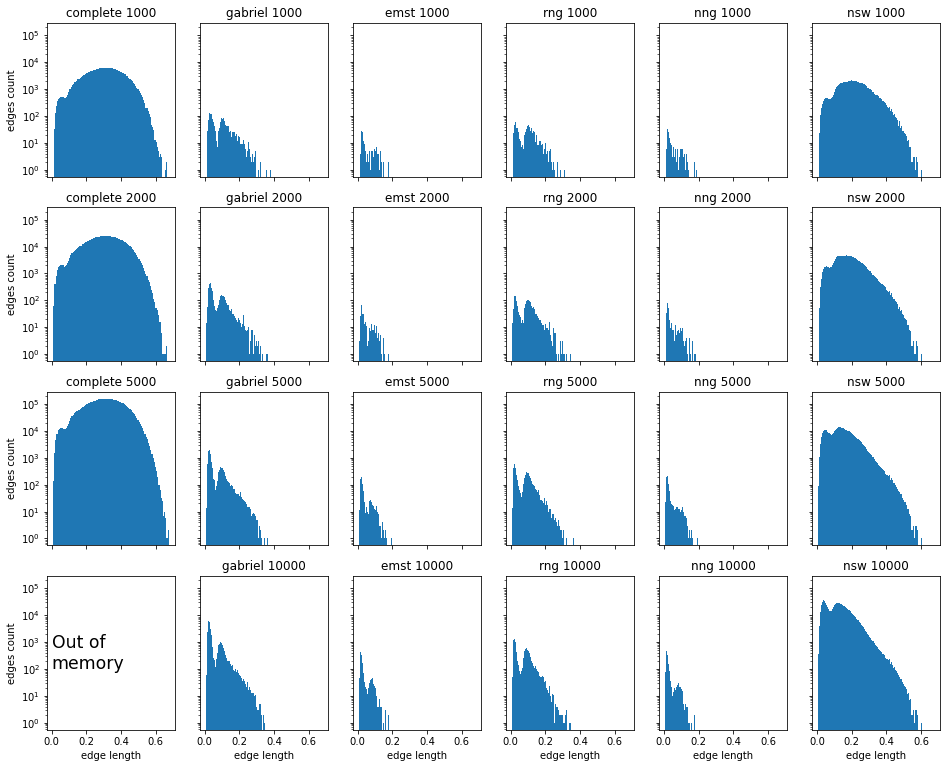

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(graph_sizes), len(graph_types), figsize=(16, 13), sharey=True, sharex=True)
plt.yscale('log')

graph_names = list(graph_types.keys())
for row in range(len(graph_sizes)):
    for col in range(len(graph_names)):
        key = (graph_names[col], graph_sizes[row])
        if key in cuts:
            data = [x[2] for x in cuts[key]]
            axs[row, col].hist(data, bins=100)
            axs[row, col].title.set_text(f"{graph_names[col]} {graph_sizes[row]}")
        axs[row, 0].set_ylabel("edges count")

for col in range(len(graph_names)):
    axs[3, col].set_xlabel("edge length")

axs[3, 0].text(0, 100, "Out of\nmemory", size='xx-large')
plt.show()

# 6.2. Examine cuts

In [19]:
from numpy.linalg import norm 

def signed_dist_to_plane(point, K, I):
    return np.dot(point, K)[0] / norm(K) - I

In [ ]:

for i, cut in enumerate(cuts):
    res = []
    for point in get_points(Xprime, cuts[cut], lim=0.05):
        r = signed_dist_to_plane(point, K, I)
        res.append(r)
    print(cut, (np.dot(res, res) / len(res)) ** .5)
    axs[i // len(graph_types), i % len(graph_types)].hist(res, bins=100)
plt.show()